In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml

# Establece el parser en 'auto' para evitar la advertencia
mnist = fetch_openml('mnist_784', version=1, parser='auto')

# Ahora puedes usar el conjunto de datos como de costumbre


In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

C:\Users\erdav\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


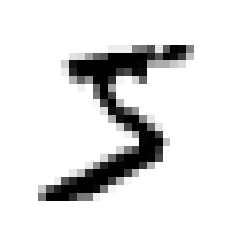

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

# Convertir los datos a un DataFrame de Pandas (opcional)
import pandas as pd
X = pd.DataFrame(X)

# Ahora puedes acceder a los datos y mostrar una imagen, por ejemplo, la primera imagen:
some_digit = X.iloc[0]  # Accede a la primera fila de X
some_digit_image = some_digit.values.reshape(28, 28)  # Convierte la fila en una imagen 28x28
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()


In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

Dividir datos en entrenamiento y prueba

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Entrenando un clasificador binario

Identicar un solo digito, si es 5 o no es 5

In [10]:
y_train_5 = (y_train == 5) # verdadero si es 5, falso los demas digitos
y_test_5 = (y_test == 5)

Elegimnos un clasificador. Un buen lugar para empezar es con el Stochastic Gradient Descent (SGD)
Este clasificador es capaz de manejar grandes conjuntos de datos eficientemente.
El SGD puede lidiar con observaciones de entrenamiento independientemente, uno a la vez.
Los usaremos en el conjunto de entrenamiento entero

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Ahora podemos usarlos para detectar imagenes con el numero 5

In [12]:
sgd_clf.predict([some_digit])

C:\Users\erdav\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

NotaL: Mezclar puede ser mala idea en algunos contextos, por ejemplo si usan series de tienpo
Arriba se hizo shuffling

## Medidas de Performance

Existen varias medidas de performance

### Medir presicion usando cross-validation

Una buena forma de evaluar un modelo es usando cross-validation.

Usaremos cross_val_score() para evaluar el modelo de SGDClassifier

K-folds significa dividir el modelo de entrenamiento en K-folds (en este caso 3)

In [13]:
>>> from sklearn.model_selection import cross_val_score
>>> cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Cerca del 95% de presicion (proporcion de predcciones correctas) en todos los folds de cross validation

Usaremos un clasificador para comparar, este compara cada imagen en la clase de 
"no es 5"

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
>>> never_5_clf = Never5Classifier()
>>> cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Tiene un 90% de presicion ya que cerca del 10% de las imagenes son 5, asi que si siempre se adivina una imagen que no es un 5, tendras presicion de un 90%.

Esto demuestra porque la presicion es generalmente no preferida como medidor de performance para clasificadores, especialmente cuando son datasets sesgados

## Matriz de confusion

Es un mejor evaluador de performance de un clasificador.
La idea general es contar el numero de veces que las observaciones son clasificadas como clase A son clasificadas como clase B. por ejemplo, para saber el numero de veces que un clasificador confunde imagenes del 5 con el 3, observaras en l quinta fila y la tercer columna en la matriz de confusion

Para calcular la matriz de confusion, primero se debe tener un set de predicciones, para que puedan ser comparados con los objetivios actuales.
Se podrian hacer predicciones con el conjunto de prueba, pero no los tocaremos por ahora. (test set se usa de preferencia al final del proyecto)

En su lugar usaremos la funcion cross_val_predict()

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Al igual que la función cross_val_score(), cross_val_predict() realiza K-fold
cross validation, pero en lugar de devolver las puntuaciones de evaluación, devuelve las predicciones realizadas en cada pliegue de la prueba. Esto significa que obtienes una predicción limpia para cada
instancia en el conjunto de entrenamiento ("limpio", lo que significa que la predicción la realiza un modelo
que nunca vio los datos durante el entrenamiento)

Ahora estamos listos para hacer una matriz de confusion

In [17]:
>>> from sklearn.metrics import confusion_matrix
>>> confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Cada fila en una matriz de confusión representa una clase real, mientras que cada columna representa
envía una clase prevista. La primera fila de esta matriz considera imágenes que no son 5 (las imágenes negativas): 53892 de ellos fueron clasificados correctamente como no 5 (se les llama verdaderos
negativos), mientras que los 687 restantes fueron clasificados erróneamente como 5 (falsos positivos).
La segunda fila considera las imágenes de 5 (la clase positiva): 1891 estaban equivocadas
clasificados como no 5 (falsos negativos), mientras que los 3530 restantes se clasificaron correctamente.
clasificados como 5 (verdaderos positivos). Un clasificador perfecto sólo tendría verdaderos positivos y verdaderos.
negativos, por lo que su matriz de confusión tendría valores distintos de cero sólo en su diagonal principal.
final (de arriba a la izquierda a abajo a la derecha):

In [18]:
>>> y_train_perfect_predictions = y_train_5 # pretendemnos que alcanzamos la perfeccion
>>> confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision y recuperacion

Calcular metricas de clasificacion

In [19]:
>>> from sklearn.metrics import precision_score, recall_score
>>> precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

Ahora su detector de 5 no se ve tan brillante como cuando observó su precisión.
Cuando afirma que una imagen representa un 5, es correcto sólo el 83,7% de las veces. Más-
Además, sólo detecta el 65,1% de los 5

A menudo es conveniente combinar precisión y recuperación en una única métrica llamada puntuación F1, en particular si necesita una forma sencilla de comparar dos clasificadores. La puntuación de F1 es
La media armónica de precisión y recuperación. Mientras que la media regular trata todos los valores por igual, la media armónica da mucho más peso a los valores bajos.
Como resultado, el clasificador sólo obtendrá una puntuación F1 alta si se cumplen tanto la recuperación como la precisión son altas.

In [21]:
## Calcular F1
>>> from sklearn.metrics import f1_score
>>> f1_score(y_train_5, y_train_pred)

0.7325171197343846

La puntuación F1 favorece a los clasificadores que tienen una precisión y recuperación similares. Esto no es siempre
lo que quieres: en algunos contextos te preocupas principalmente por la precisión, y en otros contextos
Recuerda los textos que realmente te interesan. Por ejemplo, si entrenó a un clasificador para detectar videos que son seguros para los niños, probablemente preferirías un clasificador que rechace muchos
buenos videos (baja recuperación) pero solo mantiene los seguros (alta precisión), en lugar de una clase.
clasificador que tiene una recuperación mucho mayor pero permite que aparezcan algunos videos realmente malos en tu
producto (en tales casos, es posible que incluso desee agregar una canalización humana para verificar la selección de vídeo del clasificador). Por otro lado, suponga que entrena un clasificador para detectar
ladrones en imágenes de vigilancia: probablemente esté bien si su clasificador tiene solo el 30%
precisión siempre que tenga un 99% de recuperación (seguro, los guardias de seguridad obtendrán algunos falsos
alertas, pero casi todos los ladrones serán atrapados).
**Desafortunadamente, no se pueden tener ambas cosas: aumentar la precisión reduce la recuperación y
viceversa. Esto se llama equilibrio entre precisión y recuperación**.

## Equilibrio recuperación/precisión

Scikit-Learn no le permite establecer el umbral directamente, pero sí le da acceso a
las puntuaciones de decisión que utiliza para hacer predicciones. En lugar de llamar al clasificador
método predict(), puede llamar a su método decision_function(), que devuelve un
puntuación para cada observación y luego hacer predicciones basadas en esas puntuaciones utilizando cualquier
umbral que desea:

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\erdav\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

El SGDClassifier usa un umbral igual a 0, por lo que el código anterior devuelve lo mismo
resultado como el método predict() (es decir, Verdadero). Elevemos el umbral:

In [24]:
>>> threshold = 8000
>>> y_some_digit_pred = (y_scores > threshold)
>>> y_some_digit_pred

array([False])

Esto confirma que elevar el umbral disminuye la recuperación. La imagen en realidad representa
envía un 5, y el clasificador lo detecta cuando el umbral es 0, pero lo pierde cuando el
El umbral se incrementa a 8.000.

Ahora, ¿cómo decides qué umbral usar? Para esto primero necesitarás obtener el
puntuaciones de todas las observaciones en el conjunto de entrenamiento usando la función cross_val_predict()
nuevamente, pero esta vez especificando que desea que devuelva puntuaciones de decisión en lugar de
predicciones:

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

Ahora, con estos puntajes puede calcular la precisión y recuperar todos los umbrales posibles.
viejos usando la función precision_recall_curve():

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finalmente, podemos graficar la precisión y la recuperación como funciones del valor umbral 

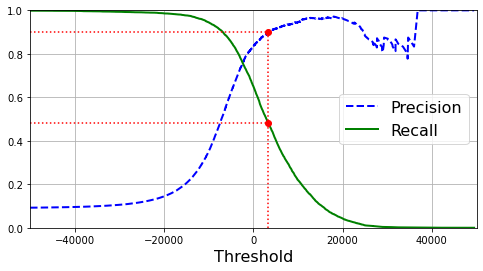

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
                                            

Entonces supongamos que decide apuntar a una precisión del 90%. Buscas la primera gráfica y
descubres que necesitas utilizar un umbral de aproximadamente 8.000. Para ser más preciso puedes
buscar el umbral más bajo que le brinde al menos un 90% de precisión (np.argmax()
nos dará el primer índice del valor máximo, que en este caso significa el primer
Verdadero valor):

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

Para hacer predicciones (en el conjunto de entrenamiento por ahora), en lugar de llamar al clasificador
método predict(), puedes simplemente ejecutar este código:

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Comprobemos la precisión de estas predicciones y recordemos:

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Tienes un clasificador de precisión del 90%! 
Un clasificador de alta precisión no es muy útil si la recuperación es demasiado baja

## Curva ROC
